In [ ]:
#!pip install datasets torchvision torch

In [ ]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Validation transforms (NO random augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
class DataSetWrapper(Dataset):
  def __init__(self, dataset, label, transform = None):
    self.dataset = dataset
    self.label = label
    self.transform = transform
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, i):
    sample = self.dataset[i]
    image = sample["image"]
    if self.transform:
      image = self.transform(image)
    label = torch.tensor(self.label, dtype=torch.long)
    return image, label


In [ ]:
class Hybrid_CNN_Vit(nn.Module):
  def __init__(self, image_size = 64,
               num_classes = 2,
               cnn_channels = 64,
               num_heads = 4,
               num_layers = 2,
               dropout = 0.2):
    super().__init__()
    self.cnn = nn.Sequential( ## CNN Feature Extractor
        #32x32
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.MaxPool2d(2),
        #16x16
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.MaxPool2d(2),
        #8x8
        nn.Conv2d(64, cnn_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.MaxPool2d(2),
    )
    # Post CNN
    self.feature_h = image_size // 8
    self.feature_w = image_size //8
    self.seq_len = self.feature_h * self.feature_w
    self.embedded_dim = cnn_channels
    # Positional embeddings for tokens
    self.positional_embeddings = nn.Parameter(
        torch.randn(1, self.seq_len, self.embedded_dim)
    )
    #Transformer Encoder
    encoder_layer = nn.TransformerEncoderLayer(
        d_model = self.embedded_dim,
        nhead=num_heads,
        dim_feedforward=self.embedded_dim * 4,
        dropout=dropout,
        activation="gelu",
        batch_first=True
    )
    self.transformer = nn.TransformerEncoder(
        encoder_layer,
        num_layers=num_layers
    )
    # Classification Head
    self.clasifier = nn.Sequential(
        nn.LayerNorm(self.embedded_dim),
        nn.Dropout(0.5),
        nn.Linear(self.embedded_dim, num_classes)
    )
  def forward(self, x):
    x = self.cnn(x)
    b, c, h, w = x.shape
    x = x.view(b, c, h * w).permute(0, 2, 1)
    x += self.positional_embeddings
    x = self.transformer(x)
    x = x.mean(dim=1)
    logits = self.clasifier(x)
    return logits

In [ ]:
def accuracy_from_logits(logits, labels):
  preds = logits.argmax(dim=1)
  return (preds==labels).float().mean().item()

In [ ]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
humans = load_dataset("kevinbenoy/anime_random_images", split = "train")
ai = load_dataset("Tomisin05/generated-anime-images", split = "train")
humans_dataset = DataSetWrapper(humans, 0, transform= None)
ai_dataset = DataSetWrapper(ai, 1, transform = None)
dataset = ConcatDataset([humans_dataset, ai_dataset])


In [ ]:
n = len(dataset)
validation_ratio = 0.2
validation_size = int(n * validation_ratio)
training_size = n - validation_size
training, testing = random_split(dataset, [training_size, validation_size])
batch_size = 128
num_workers = 2
train_transformed = TransformSubset(training, train_transform)
val_transformed = TransformSubset(testing, test_transform)
training_loader = DataLoader(train_transformed, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
testing_loader = DataLoader(val_transformed, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=True)


In [ ]:
train_class_counts = {0: 0, 1: 0}
for _, labels in training_loader:
    for label in labels:
        train_class_counts[label.item()] += 1

total = sum(train_class_counts.values())
print("Training set distribution:")
print(f"  Class 0 (Human): {train_class_counts[0]} ({100*train_class_counts[0]/total:.2f}%)")
print(f"  Class 1 (AI): {train_class_counts[1]} ({100*train_class_counts[1]/total:.2f}%)")
weight_0 = total / (2 * train_class_counts[0])
weight_1 = total / (2 * train_class_counts[1])



Training set distribution:
  Class 0 (Human): 15935 (48.63%)
  Class 1 (AI): 16833 (51.37%)


In [ ]:
# Calculate class weights
class_counts = [train_class_counts[0], train_class_counts[1]]  # Count your actual samples
class_weights = torch.tensor([1.0/train_class_counts[0], 1.0/train_class_counts[1]])
class_weights = class_weights / class_weights.sum() * 2  # Normalize

# Use in loss function


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = Hybrid_CNN_Vit(dropout=0.3).to(device)
with torch.no_grad():
    model.clasifier[-1].bias.fill_(0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
class_weights = torch.tensor([weight_0, weight_1]).to(device)
criterion = nn.CrossEntropyLoss(class_weights, label_smoothing=0.1)


Using device: cuda


In [49]:
epochs = 25
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5
patience_counter = 0
for epoch in range(1, epochs+1):
  #Training
  model.train()
  train_loss = 0.0
  train_accuracy = 0.0
  train_batches = 0
  for images, labels in training_loader:
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits,labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    train_loss += loss.item()
    train_accuracy += accuracy_from_logits(logits, labels)
    train_batches += 1
  avg_train_loss = train_loss / train_batches
  avg_train_acc = train_accuracy / train_batches
  # Validation
  all_preds = []
  all_labels = []
  all_probs = []
  model.eval()
  test_loss = 0.0
  test_acc = 0.0
  test_batches = 0
  with torch.no_grad():
    for images, labels in testing_loader:
      images = images.to(device)
      labels = labels.to(device)
      logits = model(images)
      loss = criterion(logits, labels)
      probs = torch.softmax(logits, dim=1)
      preds = logits.argmax(dim=1)
      all_preds.append(preds.cpu())
      all_labels.append(labels.cpu())
      all_probs.append(probs.cpu())

      test_loss += loss.item()
      test_acc += accuracy_from_logits(logits, labels)
      test_batches += 1
  scheduler.step()
  all_preds = torch.cat(all_preds)
  all_labels = torch.cat(all_labels)
  all_probs = torch.cat(all_probs)
  avg_test_loss = test_loss / test_batches
  avg_test_acc = test_acc / test_batches

  print(
        f"Epoch {epoch:02d}: "
        f"train_loss={avg_train_loss:.4f}, train_acc={avg_train_acc:.4f}, "
        f"test_loss={avg_test_loss:.4f}, tes_acc={avg_test_acc:.4f}"
    )
  unique_preds, pred_counts = torch.unique(all_preds, return_counts=True)
  print(f"\nPredicted label distribution:")
  for pred, count in zip(unique_preds, pred_counts):
      print(f"  Class {pred}: {count} samples ({100*count/len(all_preds):.2f}%)")
  if len(unique_preds) == 1:
      print(f"⚠️ Model is predicting ONLY class {unique_preds[0]}!")
  train_losses.append(avg_train_loss)
  train_accuracies.append(avg_train_acc)
  val_losses.append(avg_test_loss)
  val_accuracies.append(avg_test_acc)
  if avg_test_loss < best_val_loss:
    best_val_loss = avg_test_loss
    torch.save(model.state_dict(), "best_model.pth")

Epoch 01: train_loss=0.2659, train_acc=0.9619, test_loss=0.5261, tes_acc=0.7748

Predicted label distribution:
  Class 0: 2201 samples (26.87%)
  Class 1: 5991 samples (73.13%)
Epoch 02: train_loss=0.2629, train_acc=0.9634, test_loss=0.4404, tes_acc=0.8290

Predicted label distribution:
  Class 0: 2649 samples (32.34%)
  Class 1: 5543 samples (67.66%)
Epoch 03: train_loss=0.2586, train_acc=0.9666, test_loss=0.4564, tes_acc=0.8154

Predicted label distribution:
  Class 0: 2534 samples (30.93%)
  Class 1: 5658 samples (69.07%)
Epoch 04: train_loss=0.2526, train_acc=0.9702, test_loss=0.4061, tes_acc=0.8563

Predicted label distribution:
  Class 0: 2873 samples (35.07%)
  Class 1: 5319 samples (64.93%)
Epoch 05: train_loss=0.2676, train_acc=0.9605, test_loss=0.5462, tes_acc=0.7443

Predicted label distribution:
  Class 0: 1951 samples (23.82%)
  Class 1: 6241 samples (76.18%)
Epoch 06: train_loss=0.2630, train_acc=0.9638, test_loss=0.3938, tes_acc=0.8669

Predicted label distribution:
  Cl

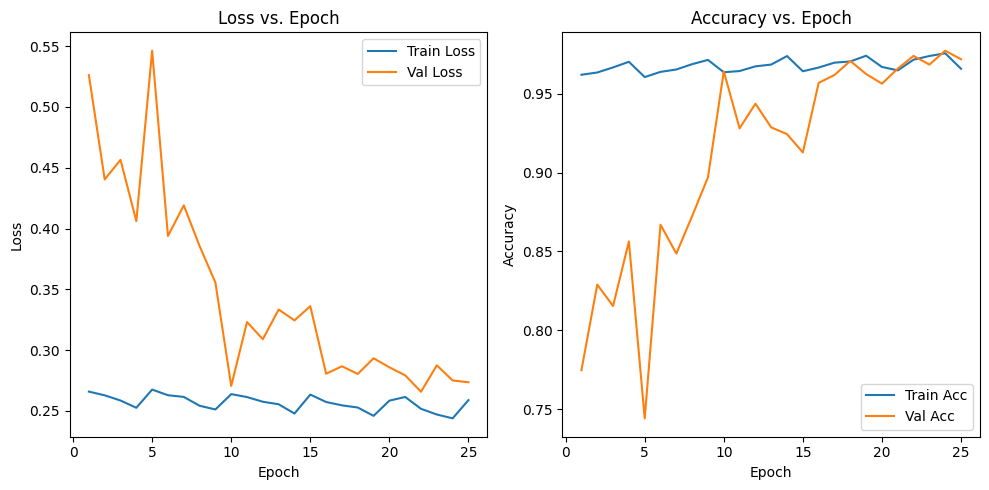

In [50]:
# Plotting
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.tight_layout()
plt.show()